<a href="https://colab.research.google.com/github/fermarquez2019/DOC_model/blob/master/modelo_DPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><font> Modelo predictivo de aprendizaje automático para determinar la recuperación de pacientes con desórdenes prolongados de conciencia</center></h1>

**Introducción:** Las lesiones cerebrales adquiridas son una de las principales causas de muerte y discapacidad, especialmente en la población joven. Entre las secuelas más graves resultantes se encuentran los desórdenes prolongados de conciencia (DPC) que abarcan el Síndrome de Vigilia sin Respuesta (SVSR, previamente denominado Estado Vegetativo) y el Estado de Conciencia Mínima (ECM). Estimar el pronóstico de estos pacientes continúa siendo un desafío para los equipos de Neurorehabilitación. 

**Objetivo:** Identificar las características que mejor explican la recuperación de la conciencia en pacientes adultos con DPC que participaron de un programa de Neurorehabilitación. 

**Sujetos y Métodos:** Estudio observacional de cohorte retrospectiva de pacientes con DPC admitidos a un programa intensivo de estimulación multisensorial de enero 2004 a septiembre 2018. Utilizando tecnología de Aprendizaje Automático (AA) se construyeron modelos  discriminantes para explicar las recuperación de la conciencia (variable dependiente). Se consideraron como variables predictoras: edad, género, etiología, tiempo de evolución desde la lesión al ingreso, diagnóstico del estado de conciencia al ingreso (SVSR-ECM), puntuación total y por dominios de la escala de Recuperación de Coma Revisada (ERC-R) y las combinaciones imposibles o improbables de las subescalas ERC-R (método Chatelle y colaboradores). Se utilizaron las librerías de software libre NumPy, Pandas, SciPy y Scikit-Learn, con el lenguaje de programación Python.

**Resultados:** Se incluyeron 62 hombres y 28 mujeres que permanecieron en el programa durante 138 días (mediana, CI: 78 - CS: 209), de los cuales el 67% del total habían ingresado en SVSR y el 33% en ECM. 26% (23/90) recuperó la conciencia durante el seguimiento. Con 63 pacientes se entrenaron 7 tipos de modelos de AA observándose mejores desempeños al incluir variables recolectadas en el seguimiento. En la validación con el conjunto de test (n=27) la red neuronal entrenada con 37 variables logró la mejor exactitud balanceada: 0.95 (Área Bajo la Curva: 0.96, Sensibilidad: 100%, Especificidad: 90%). 

**Conclusiones:** Con la tecnología de AA fue posible predecir con alta exactitud, sensibilidad y especificidad la recuperación de la conciencia de pacientes con DPC incluyendo variables recolectadas durante el primer mes de internación.

# 1. Set up

## 1.1. Instalaciones

In [1]:
!pip install tableone
!pip install shap
!pip install catboost

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394111 sha256=2549437e37fd4db1505b252046956c4d9d29c9a608f3e71dc79b1c15f8ce2291
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 65.9MB 57kB/s 


## 1.2. Librerías

In [2]:
!pwd

/content


In [3]:
#Carga de las librerías y datasets utilizados.values 
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import sklearn
import warnings
import getpass
warnings.filterwarnings("ignore")

pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.set_option('display.float_format', lambda x: '%.3g' % x)

np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.3. Carga de DFs

In [4]:
# subir a github comprimido y con contraseña
# descarga
!wget https://github.com/fermarquez2019/DOC_model/raw/master/df.zip

--2020-08-25 04:09:45--  https://github.com/fermarquez2019/DOC_model/raw/master/df.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fermarquez2019/DOC_model/master/df.zip [following]
--2020-08-25 04:09:46--  https://raw.githubusercontent.com/fermarquez2019/DOC_model/master/df.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45540 (44K) [application/zip]
Saving to: ‘df.zip’

df.zip              100%[===================>]  44.47K  --.-KB/s    in 0.02s   

2020-08-25 04:09:46 (1.82 MB/s) - ‘df.zip’ saved [45540/45540]



In [5]:
# Pasar password
passw = getpass.getpass(prompt='Password: ')
!unzip -P {passw} df.zip -d .

Password: ··········
Archive:  df.zip
  inflating: ./df_anonymous.xlsx     


## 1.4. Definir dataframe

In [6]:
# Cargar DF
df = pd.read_excel('df_anonymous.xlsx').drop('Unnamed: 0', axis=1)

# 2. Análisis exploratorio


## 2.1 General

In [7]:
df.shape

(103, 46)

In [8]:
df.columns

Index(['edad', 'genero', 'etiologia', 'edad_map', 'edad_map1', 'LOS',
       'evolucion', 'CRSi_A', 'CRSi_V', 'CRSi_M', 'CRSi_Ve', 'CRSi_C',
       'CRSi_Ar', 'CRSi_T', 'conciencia_i', 'JFK_A', 'JFK_V', 'JFK_M',
       'JFK_Ve', 'JFK_C', 'JFK_Ar', 'JFK_T', 'seguimiento', 'variacion_CRS_T',
       'variacion_CRS_A', 'variacion_CRS_V', 'variacion_CRS_C',
       'variacion_CRS_Ar', 'variacion_CRS_M', 'variacion_CRS_Ve',
       'vel_var_CRS', 'vel_var_CRS_A', 'vel_var_CRS_V', 'vel_var_CRS_C',
       'vel_var_CRS_Ar', 'vel_var_CRS_M', 'vel_var_CRS_Ve', 'CRSe_A', 'CRSe_V',
       'CRSe_M', 'CRSe_Ve', 'CRSe_C', 'CRSe_Ar', 'CRSe_T', 'conciencia_e',
       'EMERGENCIA'],
      dtype='object')

In [9]:
df.columns.duplicated().sum()

0

In [10]:
df.describe()

,edad,edad_map,edad_map1,LOS,evolucion,CRSi_A,CRSi_V,CRSi_M,CRSi_Ve,CRSi_C,CRSi_Ar,CRSi_T,JFK_A,JFK_V,JFK_M,JFK_Ve,JFK_C,JFK_Ar,JFK_T,seguimiento,variacion_CRS_T,variacion_CRS_A,variacion_CRS_V,variacion_CRS_C,variacion_CRS_Ar,variacion_CRS_M,variacion_CRS_Ve,vel_var_CRS,vel_var_CRS_A,vel_var_CRS_V,vel_var_CRS_C,vel_var_CRS_Ar,vel_var_CRS_M,vel_var_CRS_Ve,CRSe_A,CRSe_V,CRSe_M,CRSe_Ve,CRSe_C,CRSe_Ar,CRSe_T,EMERGENCIA
count,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103,103
mean,42.1,0.699,0.35,171,127,0.961,1.13,1.82,0.835,0.0583,1.31,6.11,1.76,2.08,2.85,1.24,0.311,1.8,10,23.7,3.91,0.796,0.951,0.252,0.485,1.04,0.408,0.183,0.034,0.0438,0.0114,0.0228,0.0513,0.0212,2.07,2.37,3.34,1.41,0.495,1.83,11.4,0.262
std,17.7,0.461,0.479,131,223,0.862,1.36,1.18,0.579,0.274,0.714,3.34,1.27,1.85,1.65,0.72,0.672,0.691,5.37,6.75,4.46,1.32,1.4,0.637,0.79,1.53,0.747,0.241,0.0624,0.0772,0.0301,0.0425,0.0857,0.041,1.39,2,1.94,0.81,0.815,0.793,6.74,0.442
min,18,0,0,31,14,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8,-3,-1,-2,-1,-2,-2,-1,-0.2,-0.111,-0.125,-0.04,-0.133,-0.0667,-0.037,0,0,0,0,0,0,0,0
25%,27,0,0,79,46.5,0,0,1,0.5,0,1,4,1,0,2,1,0,2,6,20.5,1,0,0,0,0,0,0,0.0408,0,0,0,0,0,0,1,0,2,1,0,1,6,0
50%,37,1,0,143,79,1,0,2,1,0,1,6,1,2,2,1,0,2,8,24,3,0,0,0,0,1,0,0.111,0,0,0,0,0.0333,0,2,3,2,1,0,2,9,0
75%,55.5,1,1,212,130,1,3,2,1,0,2,7,2,3,4,2,0,2,13,28.5,5.5,1,2,0,1,2,1,0.231,0.0436,0.0741,0,0.0417,0.0728,0.0364,4,4,5,2,1,2,17.5,1
max,81,1,1,641,2.15e+03,4,5,5,3,2,2,17,4,5,6,3,2,3,23,58,19,4,5,2,2,6,3,1.46,0.308,0.444,0.154,0.2,0.462,0.2,4,5,6,3,2,3,23,1


## 2.2. Criterios de inclusion

In [11]:
# Adultos con DPC (más de 4 semanas de evolución): SVSR o ECM según criterios actuales.
df=df.loc[df.evolucion > 30]
len(df)

97

In [12]:
# Secundario a traumatismo encefalocraneano (TEC), encefalopatía anóxica, accidente cerebrovascular (ACV) o tumor cerebral.
df=df.loc[(df.etiologia == 'TEC') | (df.etiologia == 'Anoxia') | (df.etiologia == 'ACV') | 
          (df.etiologia == 'Tumor') | (df.etiologia.isna())]
len(df)

97

In [13]:
# Edad igual o mayor a 18 años
df=df.loc[df.edad >= 18]
len(df)

97

## Criterios de exclusion

In [14]:
# Pacientes en coma.
df=df.loc[(df.conciencia_i != 'Coma') | (df.conciencia_i != 'coma')]
len(df)

97

In [15]:
# Emergencia del Estado de Conciencia Mínima antes de haber cumplido un mes en el programa de rehabilitación.
df=df.loc[df.seguimiento < 31]
len(df)

96

In [16]:
# Falta de datos de seguimiento o internación menor a un mes en el programa de rehabilitación.
df=df.loc[df.LOS > 30]
len(df)

96

In [17]:
# Emergencia del Estado de Conciencia Mínima antes de haber cumplido un mes en el programa de rehabilitación.
df=df.loc[df.CRSi_C != 2]
df=df.loc[df.CRSi_M != 6]
len(df)

95

## 2.2 Valores nulos

In [18]:
#Tabla de nulos
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
draw_missing_data_table(df)

,Total,Percent
etiologia,3,0.0316
conciencia_e,1,0.0105
EMERGENCIA,0,0
CRSi_Ar,0,0
JFK_Ar,0,0
JFK_C,0,0
JFK_Ve,0,0
JFK_M,0,0
JFK_V,0,0
JFK_A,0,0


## 2.3 Distribuciones

In [19]:
from scipy.stats import shapiro

#Columnas a testear
shapiro_cols=df.select_dtypes(exclude=['datetime','object'])

# Crear dataframes vacios
dfs = []
df_nonormal=pd.DataFrame()
df_normal = pd.DataFrame()

for column in shapiro_cols:
   # seleccionar los contenidos de las columnas con el operador [] y testear Shapiro
    columnSeries = shapiro_cols[column]
    stat, p = shapiro(columnSeries)
   # interpretar
    alpha = 0.05
    if p > alpha:
        msg = 'Gaussiana (no se puede rechazar H0)'
        # crear df con variables sin distribución normal
        df_normal[column]=columnSeries
    else:
        msg = 'No Gaussiana (rechazar H0)'
        # crear df con variables sin distribución normal
        df_nonormal[column]=columnSeries       
    
    result_mat = {'Variable':[column],'n':[len(columnSeries)], 'Estadístico': [stat], 'Valor de p':[p], 'Interpretación':[msg]}
    result = pd.DataFrame(result_mat)
    dfs.append(result)
    full = pd.concat(dfs)

full

,Variable,n,Estadístico,Valor de p,Interpretación
0,edad,95,0.923,3.13e-05,No Gaussiana (rechazar H0)
0,edad_map,95,0.585,5.68e-15,No Gaussiana (rechazar H0)
0,edad_map1,95,0.591,7.28e-15,No Gaussiana (rechazar H0)
0,LOS,95,0.852,2.58e-08,No Gaussiana (rechazar H0)
0,evolucion,95,0.339,1.05e-18,No Gaussiana (rechazar H0)
0,CRSi_A,95,0.759,3.42e-11,No Gaussiana (rechazar H0)
0,CRSi_V,95,0.764,4.79e-11,No Gaussiana (rechazar H0)
0,CRSi_M,95,0.849,2.11e-08,No Gaussiana (rechazar H0)
0,CRSi_Ve,95,0.701,1.3e-12,No Gaussiana (rechazar H0)
0,CRSi_C,95,0.202,2.35e-20,No Gaussiana (rechazar H0)


## 2.3 Tabla 1: Totales

In [20]:
from tableone import TableOne
#https://github.com/tompollard/tableone/blob/master/tableone.ipynb

data=df

# columns to summarize
columns = ['edad', 'edad_map', 'edad_map1',
           'genero', 'etiologia','evolucion','conciencia_i', 
           'LOS', 'seguimiento',
           'CRSi_A', 'CRSi_V', 'CRSi_M', 'CRSi_Ve', 'CRSi_C', 'CRSi_Ar','CRSi_T',
           'JFK_A', 'JFK_V', 'JFK_M', 'JFK_Ve', 'JFK_C', 'JFK_Ar','JFK_T',
           'conciencia_e', 
           'variacion_CRS_T', 'variacion_CRS_A','variacion_CRS_V', 'variacion_CRS_C', 'variacion_CRS_Ar',
           'variacion_CRS_M', 'variacion_CRS_Ve',
           'vel_var_CRS_A','vel_var_CRS_V', 'vel_var_CRS_C', 'vel_var_CRS_Ar', 'vel_var_CRS_M','vel_var_CRS_Ve',
           'vel_var_CRS',
           'EMERGENCIA']

# columns containing categorical variables
categorical = ['genero', 'etiologia', 'conciencia_i', 'conciencia_e', 'EMERGENCIA','edad_map', 'edad_map1']
  
# non-normal variables
nonnormal = ['edad', 'evolucion','LOS', 'CRSi_A', 'CRSi_V', 'CRSi_M', 'CRSi_Ve', 'CRSi_C', 'CRSi_Ar','CRSi_T', 
             'JFK_A', 'JFK_V', 'JFK_M', 'JFK_Ve', 'JFK_C', 'JFK_Ar','JFK_T', 'seguimiento', 
             'variacion_CRS_T', 'variacion_CRS_A','variacion_CRS_V', 'variacion_CRS_C', 'variacion_CRS_Ar',
             'variacion_CRS_M', 'variacion_CRS_Ve', 
             'vel_var_CRS', 'vel_var_CRS_A', 'vel_var_CRS_V','vel_var_CRS_C', 'vel_var_CRS_Ar', 'vel_var_CRS_M', 
             'vel_var_CRS_Ve']

# limit the binary variable to a single row
#limit = {}

# set the order of the categorical variables
#order = {}

# alternative labels
labels={'genero':'Género', 
        'etiologia':'Etiología',
        'conciencia_i':'Diagnóstico al ingreso',
        'conciencia_e':'Diagnóstico al egreso',
        'edad':'Edad', 
        'edad_map':'Edad mayor a 30 años', 
        'edad_map1':'Edad mayor a 50 años',
        'evolucion':'Evolución (días)', 
        'seguimiento':'Seguimiento (días)',
        'LOS':'Tiempo desde el ingreso al alta del prote (días)',
        'CRSi_A':'CRS-R Auditiva inicial',
        'CRSi_V':'CRS-R Visual inicial', 
        'CRSi_M':'CRS-R Motor inicial', 
        'CRSi_Ve':'CRS-R Verbal-Oromotor inicial', 
        'CRSi_C':'CRS-R Comunicación inicial', 
        'CRSi_Ar':'CRS-R Vigilia inicial', 
        'CRSi_T':'CRS-R Total inicial',
        'JFK_A':'CRS-R Auditiva al mes', 
        'JFK_V':'CRS-R Visual al mes', 
        'JFK_M':'CRS-R Motor al mes',
        'JFK_Ve':'CRS-R Verbal-Oromotor al mes', 
        'JFK_C':'CRS-R Comunicación al mes', 
        'JFK_Ar':'CRS-R Vigilia al mes',
        'JFK_T':'CRS-R Total al mes',
        'CRSe_A':'CRS-R Auditiva final',
        'CRSe_V':'CRS-R Visual final', 
        'CRSe_M':'CRS-R Motor final', 
        'CRSe_Ve':'CRS-R Verbal-Oromotor final', 
        'CRSe_C':'CRS-R Comunicación final', 
        'CRSe_Ar':'CRS-R Vigilia final', 
        'CRSe_T':'CRS-R Total final',
        'variacion_CRS_T':'Variación CRS-R Total (final-inicial)',
        'variacion_CRS_A':'Variación CRS-R Auditiva',
        'variacion_CRS_V':'Variación CRS-R Visual', 
        'variacion_CRS_C':'Variación CRS-R Comunicación', 
        'variacion_CRS_Ar':'Variación CRS-R Vigilia',
        'variacion_CRS_M':'Variación CRS-R Motor', 
        'variacion_CRS_Ve':'Variación CRS-R Verbal-Oromotor',
        'vel_var_CRS':'Tasa de variación CRS-R Total',
        'vel_var_CRS_A':'Tasa de variación CRS-R',
        'vel_var_CRS_V':'Tasa de variación CRS-R Visual',
        'vel_var_CRS_C':'Tasa de variación CRS-R Comunicación',
        'vel_var_CRS_Ar':'Tasa de variación CRS-R Vigilia',
        'vel_var_CRS_M':'Tasa de variación CRS-R Motor',
        'vel_var_CRS_Ve':'Tasa de variación CRS-R Verbal-Oromotor',
        'EMERGENCIA': 'Recuperacion de la conciencia'}

# set decimal places for age to 0
decimals = {'JFK_A':0,'JFK_V':0,'JFK_M':0,'JFK_Ve':0,'JFK_C':0,'JFK_Ar':0,'JFK_T':0,'variacion_JFKe_JFKi':0,
            'vel_var_JFK':0}

# optionally, a categorical variable for stratification
groupby = ['EMERGENCIA']

# create tableone with the input arguments
tabla_totales = TableOne(data, columns=columns, categorical=categorical, 
                   nonnormal=nonnormal, rename=labels, label_suffix=True, 
                   decimals=decimals, #limit=limit, order=order
                        )

tabla_totales

Missing             Overall
n                                                                                                95
Edad, median [Q1,Q3]                                                          0    36.0 [27.0,54.0]
Edad mayor a 30 años, n (%)                                      0            0           30 (31.6)
                                                                 1                        65 (68.4)
Edad mayor a 50 años, n (%)                                      0            0           64 (67.4)
                                                                 1                        31 (32.6)
Género, n (%)                                                    F            0           26 (27.4)
                                                                 M                        69 (72.6)
Etiología, n (%)                                                 ACV          3           17 (18.5)
                                                                 Anoxia                   21 (22.8)
                                                                 TEC                      53 (57.6)
                                                                 Tumor                      1 (1.1)
Evolución (días), median [Q1,Q3]                                              0   81.0 [53.0,138.0]
Diagnóstico al ingreso, n (%)                                    MC           0           33 (34.7)
                                                                 SVSR                     62 (65.3)
Tiempo desde el ingreso al alta del prote (días), median [Q1,Q3]              0  153.0 [82.0,217.5]
Seguimiento (días), median [Q1,Q3]                                            0    24.0 [19.0,28.5]
CRS-R Auditiva inicial, median [Q1,Q3]                                        0       1.0 [0.5,1.0]
CRS-R Visual inicial, median [Q1,Q3]                                          0       1.0 [0.0,3.0]
CRS-R Motor inicial, median [Q1,Q3]                                           0       2.0 [1.0,2.0]
CRS-R Verbal-Oromotor inicial, median [Q1,Q3]                                 0       1.0 [1.0,1.0]
CRS-R Comunicación inicial, median [Q1,Q3]                                    0       0.0 [0.0,0.0]
CRS-R Vigilia inicial, median [Q1,Q3]                                         0       1.0 [1.0,2.0]
CRS-R Total inicial, median [Q1,Q3]                                           0       6.0 [4.0,7.0]
CRS-R Auditiva al mes, median [Q1,Q3]                                         0             1 [1,2]
CRS-R Visual al mes, median [Q1,Q3]                                           0             3 [0,4]
CRS-R Motor al mes, median [Q1,Q3]                                            0             2 [2,4]
CRS-R Verbal-Oromotor al mes, median [Q1,Q3]                                  0             1 [1,2]
CRS-R Comunicación al mes, median [Q1,Q3]                                     0             0 [0,0]
CRS-R Vigilia al mes, median [Q1,Q3]                                          0             2 [2,2]
CRS-R Total al mes, median [Q1,Q3]                                            0            8 [6,13]
Diagnóstico al egreso, n (%)                                     EMCS         1           25 (26.6)
                                                                 MC                       30 (31.9)
                                                                 SVSR                     39 (41.5)
Variación CRS-R Total (final-inicial), median [Q1,Q3]                         0       3.0 [1.0,5.5]
Variación CRS-R Auditiva, median [Q1,Q3]                                      0       0.0 [0.0,1.0]
Variación CRS-R Visual, median [Q1,Q3]                                        0       0.0 [0.0,2.0]
Variación CRS-R Comunicación, median [Q1,Q3]                                  0       0.0 [0.0,0.0]
Variación CRS-R Vigilia, median [Q1,Q3]                                       0       0.0 [0.0,1.0]
Variación CRS-R Motor, median [Q1,Q3]                                   

## 2.4. Tabla 2: análisis univariado por grupos

In [21]:
# create grouped_table with p values
grouped_table = TableOne(data, columns, categorical, groupby, 
                         nonnormal, labels=labels, decimals=decimals, label_suffix=True, 
                         pval = True, smd=True, htest_name=True)
#grouped_table.to_excel('tabla1_grupos.xlsx')
grouped_table

/usr/local/lib/python3.6/dist-packages/tableone/tableone.py:206: DeprecationWarning: The labels argument is deprecated; use rename instead.
  "rename instead.", DeprecationWarning)


Grouped by Recuperacion de la conciencia                                                                                                                        
                                                                                                         Missing             Overall                   0                  1 P-Value                                       Test SMD (0,1)
n                                                                                                                                 95                  70                 25                                                             
Edad, median [Q1,Q3]                                                                                           0    36.0 [27.0,54.0]    36.5 [27.0,59.2]   35.0 [24.0,45.0]   0.111                             Kruskal-Wallis    -0.449
Edad mayor a 30 años, n (%)                                      0                                             0           30 (31.6)           20 (28.6)          10 (40.0)   0.421                                Chi-squared     0.243
                                                                 1                                                         65 (68.4)           50 (71.4)          15 (60.0)                                                             
Edad mayor a 50 años, n (%)                                      0                                             0           64 (67.4)           44 (62.9)          20 (80.0)   0.187                                Chi-squared     0.386
                                                                 1                                                         31 (32.6)           26 (37.1)           5 (20.0)                                                             
Género, n (%)                                                    F                                             0           26 (27.4)           21 (30.0)           5 (20.0)   0.483                                Chi-squared     0.232
                                                                 M                                                         69 (72.6)           49 (70.0)          20 (80.0)                                                             
Etiología, n (%)                                                 ACV                                           3           17 (18.5)           15 (22.4)            2 (8.0)   0.084  Chi-squared (warning: expected count < 5)       nan
                                                                 Anoxia                                                    21 (22.8)           17 (25.4)           4 (16.0)                                                             
                                                                 TEC                                                       53 (57.6)           35 (52.2)          18 (72.0)                                                             
                                                                 Tumor                                                       1 (1.1)                                1 (4.0)                                                             
Evolución (días), median [Q1,Q3]                                                                               0   81.0 [53.0,138.0]   87.0 [59.0,144.5]  61.0 [39.0,113.0]   0.046                             Kruskal-Wallis    -0.281
Diagnóstico al ingreso, n (%)                                    MC                                            0           33 (34.7)           15 (21.4)          18 (72.0)  <0.001                                Chi-squared     1.176
                                                                 SVSR                                                      62 (65.3)           55 (78.6)           7 (28.0)                                                             
Tiempo desde el ingreso al alta del prote (días), median [Q1,Q3]                                               

## 2.5. Exploración gráfica de variables

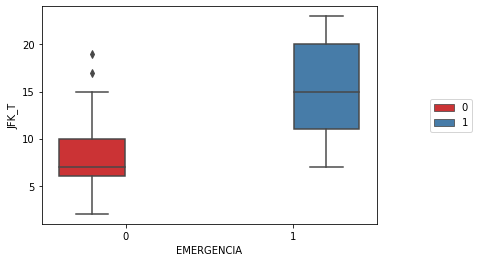

In [22]:
# Grouped boxplot
ax=sns.boxplot(x="EMERGENCIA", y="JFK_T", hue="EMERGENCIA", data=df, palette="Set1")
#sns.plt.show()
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

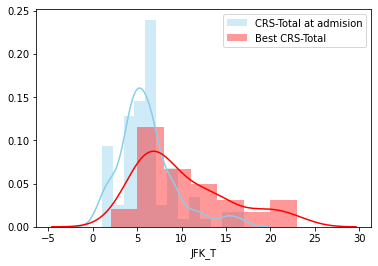

In [23]:
# Method 1: on the same Axis
sns.distplot( df["CRSi_T"] , color="skyblue", label="CRS-Total at admision")
sns.distplot( df["JFK_T"] , color="red", label="Best CRS-Total")
plt.legend()

## 2.6. Pairplots
Realizamos pairplots para visualizar la relación entre cada variable y separamos los colores de acuerdo a la variable dependiente.

In [24]:
cols=['edad','evolucion','CRSi_A', 'CRSi_V', 'CRSi_M', 'CRSi_Ve', 'CRSi_C', 'CRSi_Ar','CRSi_T',
       'JFK_A', 'JFK_V', 'JFK_M','JFK_Ve', 'JFK_C', 'JFK_Ar', 'JFK_T','EMERGENCIA']
#sns_plot=sns.pairplot(df[cols], hue="EMERGENCIA", markers=["o", "s"])
#sns_plot.savefig("pairplot.png")

## 2.6. Correlaciones entre las variables

In [25]:
# Funcion para calcular la correlacion
# Nos permite usar pearson o spearman, y devuelve p value
from scipy.stats import pearsonr, spearmanr

def correlate(df, corr=pearsonr):
    matrix = df.values.T
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            r_, p_ = corr(matrix[i], matrix[j])
            r[i, j] = r[j, i] = r_
            p[i, j] = p[j, i] = p_
    return r, p

In [26]:
cols = df.select_dtypes(include=[np.number]).columns
corrs, ps = correlate(df[cols], spearmanr)

# columna a correlacionar con las demás
col_corr = 'EMERGENCIA'  
col_corr_idx = cols.get_loc(col_corr)

# guardamos las correlaciones en un dataframe
corr_df = pd.DataFrame(corrs[col_corr_idx], cols, columns=['coef'])
corr_df['p'] = ps[col_corr_idx]

corr_df = corr_df.iloc[corr_df['coef'].abs().argsort().values[::-1], :]
corr_df[(np.abs(corr_df['coef']) > 0.2) & (corr_df['p'] < 1e-5)]

,coef,p
CRSe_C,0.875,5.47e-31
CRSe_M,0.746,4.13e-18
CRSe_A,0.731,4.12e-17
CRSe_V,0.731,4.16e-17
CRSe_T,0.69,1.08e-14
CRSe_Ve,0.622,1.74e-11
JFK_T,0.575,1.14e-09
JFK_C,0.557,4.53e-09
JFK_V,0.535,2.26e-08
CRSe_Ar,0.532,2.91e-08


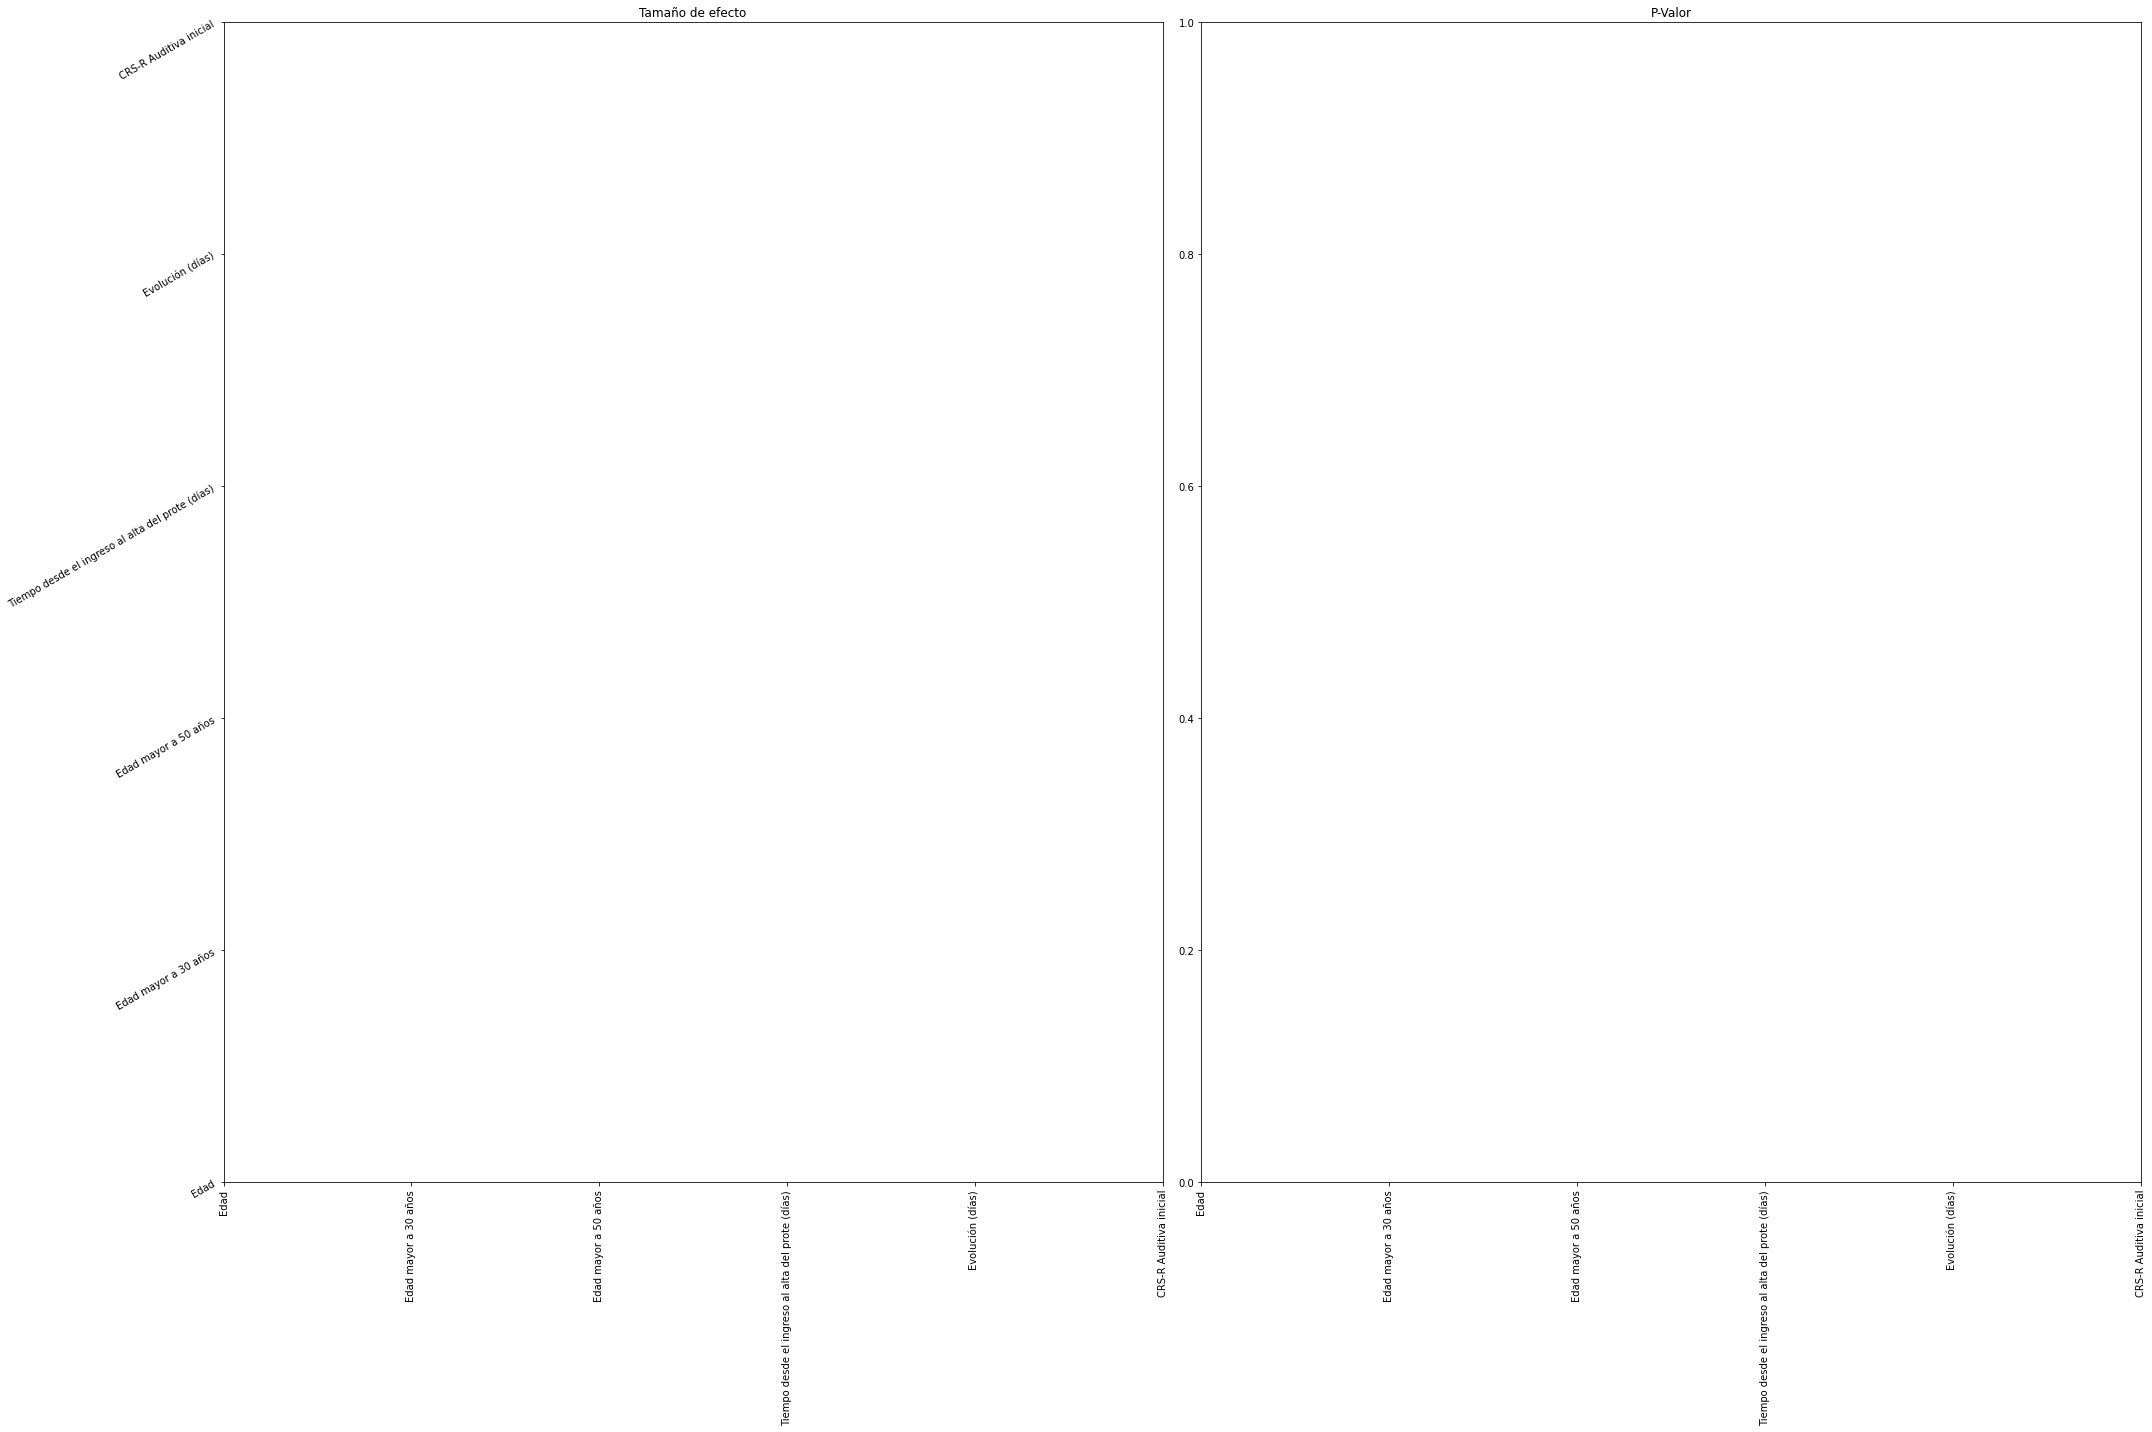

In [27]:
# Ploteamos todas las correlaciones y los p valores

cols = [labels[c] for c in cols]

fig, ax = plt.subplots(1, 2, figsize=(30,20))

#sns.heatmap(corrs, ax=ax[0], cbar=False, annot=True, linewidths=1, fmt='.2f', annot_kws={"size":6})
ax[0].set_title('Tamaño de efecto')
ax[0].set_yticklabels(cols, rotation=30)
ax[0].set_xticklabels(cols, rotation=90)

#sns.heatmap(ps, ax=ax[1], annot=True, cbar=False, linewidths=1, fmt='.2f',annot_kws={"size": 6});
ax[1].set_title('P-Valor');
ax[1].set_xticklabels(cols, rotation=90)
plt.tight_layout()
plt.savefig("heatmap_spearman_all.png")

# 3. Preprocesado

## 3.1 Crear copia del DF no preprocesado
Esta copia tiene como objetivo guardar el DF sin valores escalados (con codifcaciones y variables originales) para analisis exploratorio cuando sea necesario

In [28]:
df_copy=df.copy()

## 3.2. Get dummies

In [29]:
#Get dummies
df=pd.get_dummies(data=df, columns=['conciencia_i','genero', 'etiologia'], prefix = 'cat', drop_first=True)

## 3.3. Eliminación de columnas no utilizadas

In [30]:
df = df.drop(['conciencia_e','LOS',
              'CRSe_A','CRSe_V', 'CRSe_M', 'CRSe_Ve', 'CRSe_C','CRSe_Ar', 'CRSe_T'
              ], axis=1)

## 3.4. Renombrado de columnas

In [31]:
#Dict to rename cols
dict_cols= {'CRSi_A':'CRSiA', 'CRSi_V':'CRSiV','CRSi_M':'CRSiM', 'CRSi_Ve':'CRSiVe', 'CRSi_C':'CRSiC', 
            'CRSi_Ar':'CRSiAr','CRSi_T':'CRSiT'}
#Rename cols
df=df.rename(columns=dict_cols)

## 3.5. Normalización

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
y = df['EMERGENCIA']
df = df.drop('EMERGENCIA', axis=1)
df[:] = scaler.fit_transform(df.values)
df['EMERGENCIA'] = y  

## 3.6 Imputación de valores faltantes

- Completamos los nulos con la mediana por ser más robusta a valores extremos. Podríamos hacer df.groupby(sexo, edad).median(), en vez de la mediana

In [33]:
# Fill nans with median
df_fill = df.fillna(df.median())

# 4. Splits

## 4.1. Primer split
Para guardar el held out

In [34]:
X=df.drop('EMERGENCIA', axis=1)
y=df['EMERGENCIA']

from sklearn.model_selection import train_test_split
# split data train 70 % and test 30 %
X, X_held_out, y, y_held_out = train_test_split(X, y, test_size=0.3, stratify=y)

In [35]:
print('Tamaño X', len(X), '\n',
      'Clases y','\n', y.value_counts(),'\n','\n',
      'Tamaño X_held_out', len(X_held_out), '\n',
      'Clases y_held_out','\n', y_held_out.value_counts())

Tamaño X 66 
 Clases y 
 0    49
1    17
Name: EMERGENCIA, dtype: int64 
 
 Tamaño X_held_out 29 
 Clases y_held_out 
 0    21
1     8
Name: EMERGENCIA, dtype: int64


## 4.2. Segundo split 
Relizamos un nuevo split para entrenar y testear. Hatsa el momento hemos guardado el Held Out para validar el mejor modelo que surja del entrenamiento.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

In [37]:
print('Tamaño X_train', len(X_train), '\n',
      'Clases y_train','\n', y_train.value_counts(),'\n','\n',
      'Tamaño X_test', len(X_test), '\n',
      'Clases y_test','\n', y_test.value_counts())

Tamaño X_train 52 
 Clases y_train 
 0    39
1    13
Name: EMERGENCIA, dtype: int64 
 
 Tamaño X_test 14 
 Clases y_test 
 0    10
1     4
Name: EMERGENCIA, dtype: int64


# 5. Selección de variables

## 5.1. Criterios Estadísticos

### 5.1.A. Eliminación recursiva de variables con Random Forrest y Cross Validation

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [39]:
clf_rf = RandomForestClassifier(max_depth=15) 
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='balanced_accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

# save best features in list
RFECV_feats=(X_train.columns[rfecv.support_].values).tolist()

# The "accuracy" scoring is proportional to the number of correct classifications
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 19
Best features : Index(['edad', 'evolucion', 'CRSiA', 'CRSiV', 'CRSiM', 'CRSiT', 'JFK_V',
       'JFK_M', 'JFK_Ve', 'JFK_C', 'JFK_T', 'seguimiento', 'variacion_CRS_T',
       'variacion_CRS_Ar', 'variacion_CRS_M', 'vel_var_CRS_V',
       'vel_var_CRS_Ar', 'vel_var_CRS_M', 'cat_SVSR'],
      dtype='object')


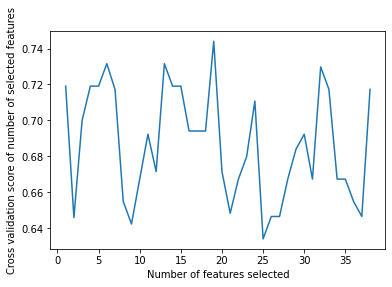

In [40]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature ranking:
1. feature JFK_T: 0.0555
2. feature CRSiT: 0.0035
3. feature edad: 0.0071
4. feature CRSiV: 0.0500
5. feature evolucion: 0.0449
6. feature variacion_CRS_T: 0.0512
7. feature CRSiA: 0.0283
8. feature JFK_M: 0.0027
9. feature JFK_V: 0.0066
10. feature JFK_A: 0.0164
11. feature vel_var_CRS_Ar: 0.0687
12. feature JFK_C: 0.0398
13. feature cat_SVSR: 0.0431
14. feature vel_var_CRS_M: 0.0432
15. feature JFK_Ve: 0.0316
16. feature CRSiM: 0.0335
17. feature vel_var_CRS_V: 0.0155
18. feature variacion_CRS_Ar: 0.0942
19. feature variacion_CRS_M: 0.0208
20. feature seguimiento: 0.0469
21. feature vel_var_CRS: 0.0114
22. feature vel_var_CRS_A: 0.0154
23. feature vel_var_CRS_C: 0.0028
24. feature cat_TEC: 0.0223
25. feature CRSiAr: 0.0213
26. feature JFK_Ar: 0.0074
27. feature variacion_CRS_V: 0.0190
28. feature variacion_CRS_A: 0.0189
29. feature vel_var_CRS_Ve: 0.0243
30. feature variacion_CRS_Ve: 0.0169
31. feature edad_map1: 0.0356
32. feature CRSiC: 0.0319
33. feature cat_M: 0.

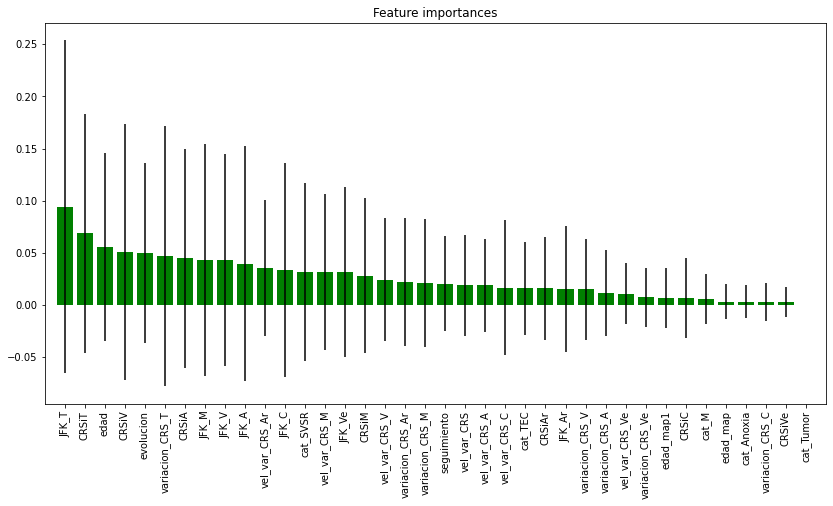

In [41]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f+1}. feature {X_train.columns[indices[f]]}: {importances[f]:.4f}")

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### 5.1.B. Análisis multivariable

In [42]:
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab

In [43]:
# 1. definir X_logit eliminando columnas con un unico valor
X_train_logit=X_train.loc[:,X_train.apply(pd.Series.nunique) != 1]
# 2. get linearity
Q,R = np.linalg.qr((X_train_logit.values))
# get linearity dependent columns with boolean array
linearly_dependents_cols=(X_train_logit.T[np.abs(np.diag(R))<=1e-10]).T.columns
# eliminar columnas linearmente dependientes
X_train_logit = X_train_logit.drop(linearly_dependents_cols, axis=1)

linearly_dependents_cols

Index(['CRSiT', 'variacion_CRS_T', 'variacion_CRS_A', 'variacion_CRS_V',
       'variacion_CRS_C', 'variacion_CRS_Ar', 'variacion_CRS_M',
       'variacion_CRS_Ve'],
      dtype='object')

In [51]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

min_variance = 0.5
low_variance = variance_threshold_selector(X_train_logit, min_variance) 

print('columns removed:', X_train_logit.columns.difference(low_variance.columns))
X_train_logit = low_variance

columns removed: Index([], dtype='object')


In [52]:
#X_train_logit['intercepto'] = 1.0

In [53]:
#cols=logit_df_constant.columns[:-1]
model=sm.Logit(y_train,X_train_logit)
result=model.fit(method='cg', maxiters=1000) #methosd: 'bfgs', 'nm', 'newton' fit_regularized(method='l1')
result.summary()

         Current function value: 0.005308
         Iterations: 35
         Function evaluations: 109
         Gradient evaluations: 109


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             EMERGENCIA   No. Observations:                   52
Model:                          Logit   Df Residuals:                       25
Method:                           MLE   Df Model:                           26
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                  0.9906
Time:                        04:11:26   Log-Likelihood:               -0.27602
converged:                      False   LL-Null:                       -29.241
Covariance Type:            nonrobust   LLR p-value:                 0.0003161
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
edad             -19.5059     44.026     -0.443      0.658    -105.795      66.783
edad_map          -0.5501     17.579     -0.031      0.975     -35.004      33.904
edad_map1         20.6505     42.561      0.485      0.628     -62.768     104.069
evolucion         -0.5522      3.344     -0.165      0.869      -7.106       6.001
CRSiA             10.1565    138.813      0.073      0.942    -261.913     282.226
CRSiV             16.0702     65.092      0.247      0.805    -111.507     143.648
CRSiM             -0.5921     14.381     -0.041      0.967     -28.779      27.594
CRSiVe            11.0083     29.164      0.377      0.706     -46.152      68.168
CRSiC              9.1424     79.616      0.115      0.909    -146.902     165.186
CRSiAr            -7.1729     40.288     -0.178      0.859     -86.135      71.789
JFK_A             -2.5971    203.193     -0.013      0.990    -400.848     395.654
JFK_V             -3.9260     89.113     -0.044      0.965    -178.585     170.733
JFK_M              0.0156     58.524      0.000      1.000    -114.690     114.721
JFK_Ve            -2.6683     60.775     -0.044      0.965    -121.785     116.448
JFK_C             -5.7891    252.750     -0.023      0.982    -501.171     489.592
JFK_Ar             3.2888     53.128      0.062      0.951    -100.841     107.418
JFK_T             -4.7580    193.087     -0.025      0.980    -383.201     373.685
seguimiento        9.8920     21.453      0.461      0.645     -32.156      51.940
vel_var_CRS_A      2.4449    282.064      0.009      0.993    -550.391     555.281
vel_var_CRS_V      6.0949     70.460      0.087      0.931    -132.004     144.194
vel_var_CRS_C     10.7208    317.258      0.034      0.973    -611.094     632.536
vel_var_CRS_Ar     2.7710     56.594      0.049      0.961    -108.152     113.694
vel_var_CRS_Ve    17.1746     57.954      0.296      0.767     -96.413     130.763
cat_SVSR           7.2760     29.716      0.245      0.807     -50.966      65.518
cat_M             -2.5922      9.220     -0.281      0.779     -20.663      15.479
cat_Anoxia        -5.0161     13.543     -0.370      0.711     -31.560      21.528
cat_TEC            3.8901     17.297      0.225      0.822     -30.011      37.791
==================================================================================

Possibly complete quasi-separation: A fraction 0.40 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [54]:
def back_feature_elem (data_frame,dep_var,col_list, reg=False, method=None):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list], method=method)
        if reg:
          result=model.fit_regularized()
        else:
          result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,6).nlargest(1)
        if largest_pvalue[0]<(0.05):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(X_train_logit,y_train, X_train_logit.columns, reg=True)
result.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4277183761678028e-10
            Iterations: 65
            Function evaluations: 65
            Gradient evaluations: 65
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.426054744032493e-11
            Iterations: 70
            Function evaluations: 71
            Gradient evaluations: 70
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0360851518816943e-10
            Iterations: 61
            Function evaluations: 61
            Gradient evaluations: 61
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.198438607387376e-11
            Iterations: 96
            Function evaluations: 97
            Gradient evaluations: 96
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1284643317826858e-10
            Iterations: 122


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             EMERGENCIA   No. Observations:                   52
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            0
Date:                Tue, 25 Aug 2020   Pseudo R-squ.:                 0.04879
Time:                        04:11:31   Log-Likelihood:                -27.815
converged:                       True   LL-Null:                       -29.241
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
JFK_T          1.4903      0.460      3.241      0.001       0.589       2.392
==============================================================================
"""

In [55]:
params = np.exp(result.params)
conf = np.exp(result.conf_int())
conf['OR'] = params
pvalue=round(result.pvalues,6)
conf['pvalue']=pvalue
conf.columns = ['CI 95%(2.5%)', 'CI 95%(97.5%)', 'Odds Ratio','pvalue']
print ((conf))

       CI 95%(2.5%)  CI 95%(97.5%)  Odds Ratio  pvalue
JFK_T           1.8           10.9        4.44 0.00119


#### 5.1.B.1. Crear set de variables independientes en un array 

In [56]:
#get independent variable names and save array
multivariable=conf.index.values
multivariable

array(['JFK_T'], dtype=object)

Encontramos que la unica variable independientes asociadas a la recuperación de la conciencia fue la Puntuación Total en la durante el seguimiento en la Escala de Coma Revisada (JFK_T)

### 5.1.C. Eliminación por correlaciones 

Spearman

- Criterio: eliminar variables con correlaciones con rho Spearman >=0.7

In [57]:
#https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

corr = X_train.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = X_train.columns[columns]
data_correlation = X_train[selected_columns]
selected_columns.values

array(['edad', 'evolucion', 'CRSiA', 'CRSiV', 'CRSiM', 'CRSiVe', 'CRSiC',
       'CRSiAr', 'JFK_A', 'JFK_V', 'JFK_M', 'JFK_Ve', 'JFK_Ar',
       'seguimiento', 'variacion_CRS_V', 'variacion_CRS_Ar', 'cat_SVSR',
       'cat_M', 'cat_Anoxia', 'cat_TEC', 'cat_Tumor'], dtype=object)

In [58]:
spearman=selected_columns.values

## 5.2. Criterios clínicos

Para poder comparar el poder predictivo y responder a la pregunta si es mejor predecir la recuperación de un paciente al momento de la admision en internción (ingreso) o durante el el primer mes (seguimiento) definiremos dos puntos de corte de selección de variables.

### 5.2.A. Variables registradas al momento de la admisión (ingreso)

In [59]:
ingreso=['edad','evolucion','seguimiento','cat_SVSR', 'cat_M', 
          'cat_Anoxia', 'cat_TEC','cat_Tumor',
          'CRSiA', 'CRSiV', 'CRSiM', 'CRSiVe', 'CRSiC', 'CRSiAr','CRSiT']

### 4.2.A. Variables registradas durante el primer mes (seguimiento)

In [60]:
seguimiento=['edad','evolucion','seguimiento','cat_SVSR', 'cat_M', 
          'cat_Anoxia', 'cat_TEC','cat_Tumor',
          'CRSiA', 'CRSiV', 'CRSiM', 'CRSiVe', 'CRSiC', 'CRSiAr','CRSiT', 
          'JFK_A', 'JFK_V', 'JFK_M','JFK_Ve', 'JFK_C', 'JFK_Ar', 'JFK_T',
          'variacion_CRS_A', 'variacion_CRS_V', 'variacion_CRS_C','variacion_CRS_Ar', 
          'variacion_CRS_M', 'variacion_CRS_Ve','variacion_CRS_T',
          'vel_var_CRS_A', 'vel_var_CRS_V', 'vel_var_CRS_C','vel_var_CRS_Ar', 
          'vel_var_CRS_M','vel_var_CRS_Ve', 'vel_var_CRS']

## 5.3. Criterio mixto
El criterio mixto es una combinacion de los resultados del analisis exploratorio, de la selección por RFECV y la importancia de las variables, el análisis multivariable, las correlaciones y el criterio médico-técnico de los autores.

In [61]:
mixto=['edad', 'CRSiV', 'CRSiM', 'CRSiT', 'evolucion', 'JFK_A', 'JFK_V',
       'JFK_M', 'JFK_C', 'JFK_T', 'seguimiento', 'variacion_CRS_T',
       'variacion_CRS_V', 'variacion_CRS_M', 'vel_var_CRS', 'vel_var_CRS_A',
       'vel_var_CRS_V', 'vel_var_CRS_Ar', 'cat_TEC']       

## 5.4. Diccionario de seleccion de variables

In [62]:
feats = dict(
    RFECV_feats=RFECV_feats,
    spearman=spearman,
    multivariable=multivariable,
    mixto=mixto,
    ingreso=ingreso,
    seguimiento=seguimiento
    )

# 6. Aprendizaje supervisado



In [63]:
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix, roc_auc_score, balanced_accuracy_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## 6.1. Definir funcion make_random_model
- Utilizamos Random Search para busqueda aleatoria de mejores parámetros. Además de ser más económico que Grid Search por no probar todos los elementos, Random Search puede encontrar combinaciones de parámetros mejores que Grid Search, ya que trabaja en el dominio de los reales en vez de estar limitado por la grilla definida por el usuario.

In [64]:
def make_random_model(clf, X, y, params, n_splits=10, split=False, verbose=0, test_size=0.2, **kwargs):
    if split:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    else:
      X_train, y_train = X, y
    #kf = StratifiedKFold(n_splits=splits,shuffle=True,random_state=11)
    #gs = GridSearchCV(clf,param_grid=params,cv=kf,return_train_score=True,**kwargs)
    kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    rscv = RandomizedSearchCV(clf, param_distributions = params, cv = kf, return_train_score=True, 
                              scoring=scoring,**kwargs)
    model = rscv.fit(X_train, y_train)
    test_score_mean = np.mean(model.cv_results_['mean_test_score'])
    test_score_std = np.std(model.cv_results_['mean_test_score'])
    train_score_mean = np.mean(model.cv_results_['mean_train_score'])
    train_score_std = np.std(model.cv_results_['mean_train_score'])
    if verbose:
      print('Best params:'), 
      pprint(model.best_params_)
      print(f"Mean CV score: {score:.3g}")
    return model.best_estimator_, model.best_params_, test_score_mean, test_score_std, train_score_mean, train_score_std

## 6.2. Setting de modelos de boosting

- Los modelos de boosting son un tipo de ensamble que entrena cada modelo utilizando los errores o residuos del modelo anterior, mejorando secuencialmente. Son de las herramientas más potentes dentro de "shallow machine learning".

In [65]:
xgb = XGBClassifier(
        #n_jobs = -1,
        objective = 'binary:logistic',
        verbosity=0,
        #tree_method='gpu_hist'
        )
params_xgb = {'n_estimators': [1,2,3,4,5,10,15,20,50,100, 200, 500, 750, 1000],
              'learning_rate': [0.001,0.01,0.05,0.1,0.3, 0.5, 1],
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 20],
              'max_depth': range(3,90,5),
              'min_child_weight':[1, 2, 4, 6, 8, 10, 12],
              'gamma':[1/i for i in range(1,100,5)],
              'subsample':[1/i for i in range(1,100,5)],
              'colsample_bytree':[1/i for i in range(1,50,2)],
              'scale_pos_weight': [1,5,10,50]}

cat = CatBoostClassifier(loss_function='Logloss',
                         verbose = False,
                         thread_count=-1,
                         #task_type="GPU"
                         )
params_cat = {'depth':range(2,16,2),
              'iterations':[100,250,500, 750],
              'learning_rate':[0.001,0.01,0.05,0.1,0.3, 0.5, 1], 
              'l2_leaf_reg':[3,5,10,20,100],
              'border_count':[20,50,100,200,250],
              'scale_pos_weight': [1,5,10,50]}

lgbm = LGBMClassifier()
params_lgbm = {'learning_rate': [0.001,0.01,0.05,0.1,0.3, 0.5, 1],
                'num_leaves': range(2,100,10),      
                'max_depth': range(3,90,5),
                'min_child_samples': range(0, 50,10),
                'max_bin': range(100, 1000, 100),
                'subsample': [1/i for i in range(1, 100, 10)],
                'colsample_bytree': [1/i for i in range(1, 100, 10)],
                'reg_lambda': [1e-9, 1e-2, 0.1, 1, 10, 100, 1000],
                'reg_alpha': [1e-5, 1e-2, 0.1, 1, 10, 20],
                'scale_pos_weight': [1,5,10,50],
                'min_data_in_leaf': range(10, 1000, 100),
                'feature_fraction': [0.001,0.01,0.05,0.1,0.3, 0.5, 1],
                'n_estimators': [1,2,3,4,5,10,15,20,50,100, 200, 500, 750, 1000]}

## 6.3. Setting del resto de modelos

In [66]:
rf = RandomForestClassifier()
params_rf =  {'criterion': ['gini', 'entropy'],
              'n_estimators': [1,2,3,4,5,10,15,20,50],
              'max_depth': range(3,90,5)}

svc = SVC()
params_svc = {'kernel': ['rbf', 'linear'], 'C': [1, 10, 100, 1000], 'gamma': [0.0001,0.001, 0.01, 0.1,1, 10], 
              'probability':[True]}   

DTree = DecisionTreeClassifier()
params_dtree = {'criterion': ['gini', 'entropy'],
                'max_depth': range(3,90,5)}

knn = KNeighborsClassifier()
params_knn =  {'n_neighbors': [2,4,8,16]}

logit = LogisticRegression()
#para logit definimos dos diccionarios ya que el penalty L1 no admite los solver 'newton-cg','sag' ni 'lbfgs'
params_logitL1 = {'penalty': ['l1'],"C": np.logspace(-1, 2, 10),"solver":['saga','liblinear']}
params_logitL2 = {'penalty': ['l2'],"C": np.logspace(-1, 2, 10),"solver":['newton-cg','saga','sag','liblinear',
                                                                          'lbfgs']}

mlp = MLPClassifier()
params_mlp = {'hidden_layer_sizes': range(1,200,10) , 
              'activation': ['tanh','logistic','relu'],
              'alpha':[0.0001,0.001,0.01,0.1,1,10], 
              'max_iter': range(50,200,50)}

gnb = GaussianNB()
params_gnb = {'priors': [None]}

## 6.4. Diccionario con todos los modelos y parametros

In [67]:
model_dict = {'LGBM': {'model':lgbm,
                       'param_random':params_lgbm},
              'CAT': {'model':cat,
                      'param_random':params_cat},
              'XGB': {'model': xgb,
                      'param_random':params_xgb},
              'RF': {'model': rf,
                      'param_random':params_rf},
              'SVC': {'model': svc,
                      'param_random':params_svc},
              'DTree': {'model': DTree,
                      'param_random':params_dtree},
              'KNN': {'model': knn,
                      'param_random':params_knn},
              'LOGITl1': {'model': logit,
                      'param_random':params_logitL1},
              'LOGITl2': {'model': logit,
                      'param_random':params_logitL2},
              'MLP': {'model': mlp,
                      'param_random':params_mlp},
              'GNB' : {'model': gnb, 
                       'param_random':params_gnb}
              }

## 6.5. Entrenamiento

In [68]:
from time import strftime
from IPython.display import display, HTML
#from pprint import pprint

train_df = pd.DataFrame()
 
# Iteramos cada dataset
for k in feats:
  print(f'\n\nEntrenando con {k}')
  X_train_, X_test_ = X_train[feats[k]], X_test[feats[k]]

  print(f'FEATURE SET {k.upper()}')
  # Iteramos cada modelo
  for m in model_dict:
    # Metricas con las que elegir el mejor candidato
    for scoring in ['balanced_accuracy']:
      # grilla de parametros
      params = model_dict[m]['param_random']
      
      # cross validation dentro de train
      model, params, test_score_mean, test_score_std, train_score_mean, train_score_std = make_random_model(
                                                                  model_dict[m]['model'],
                                                                  X_train_,y_train,params,
                                                                  n_iter=50,random_state=42,
                                                                  test_size=0.2,split=False)
      
      # evaluamos en test (CON ESTAS PRUEBAS AJUSTAMOS AL TEST SET, ES NECESARIO SEPARAR UNO DE VALICACIÓN)
      y_pred = model.predict(X_test_)
      
      print(m, scoring, f"{test_score_mean:.5f}, en CV del Train")
      #print(classification_report(y_test, y_pred))
      res = classification_report(y_test, y_pred, output_dict=True) 
      res = pd.json_normalize(res, sep='_').iloc[0].to_dict()
      res['model'] = m
      res['test_balanced_accuracy'] = balanced_accuracy_score(y_test, y_pred)
      res['roc'] = roc_auc_score(y_test, y_pred)
      res['cv_test_score_mean'] = test_score_mean
      res['cv_test_score_std'] = test_score_std
      res['cv_train_score_mean'] = train_score_mean
      res['cv_train_score_std'] = train_score_mean      
      res['scoring'] = scoring
      res['feats'] = k
      
      res.update(params)
      #pprint(res)

      train_df = train_df.append(res, True)

display(train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].dropna(axis=1).sort_values(by='test_balanced_accuracy', ascending=False))



Entrenando con RFECV_feats
FEATURE SET RFECV_FEATS
LGBM balanced_accuracy 0.50117, en CV del Train
CAT balanced_accuracy 0.65546, en CV del Train
XGB balanced_accuracy 0.50908, en CV del Train
RF balanced_accuracy 0.62254, en CV del Train
SVC balanced_accuracy 0.66710, en CV del Train
DTree balanced_accuracy 0.63131, en CV del Train
KNN balanced_accuracy 0.60156, en CV del Train
LOGITl1 balanced_accuracy 0.68542, en CV del Train
LOGITl2 balanced_accuracy 0.70804, en CV del Train
MLP balanced_accuracy 0.72996, en CV del Train
GNB balanced_accuracy 0.71667, en CV del Train


Entrenando con spearman
FEATURE SET SPEARMAN
LGBM balanced_accuracy 0.50000, en CV del Train
CAT balanced_accuracy 0.72188, en CV del Train
XGB balanced_accuracy 0.51013, en CV del Train
RF balanced_accuracy 0.70333, en CV del Train
SVC balanced_accuracy 0.66432, en CV del Train
DTree balanced_accuracy 0.68432, en CV del Train
KNN balanced_accuracy 0.61250, en CV del Train
LOGITl1 balanced_accuracy 0.65531, en CV d

,model,0_f1-score,0_precision,0_recall,0_support,1_f1-score,1_precision,1_recall,1_support,accuracy,cv_test_score_mean,cv_test_score_std,cv_train_score_mean,cv_train_score_std,feats,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,roc,scoring,test_balanced_accuracy,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support
16,DTree,0.842,0.889,0.8,10,0.667,0.6,0.75,4,0.786,0.684,0.0339,0.993,0.993,spearman,0.754,0.744,0.775,14,0.775,balanced_accuracy,0.775,0.792,0.806,0.786,14
65,GNB,0.909,0.833,1,10,0.667,1,0.5,4,0.857,0.627,0,0.833,0.833,seguimiento,0.788,0.917,0.75,14,0.75,balanced_accuracy,0.75,0.84,0.881,0.857,14
32,GNB,0.909,0.833,1,10,0.667,1,0.5,4,0.857,0.681,0,0.719,0.719,multivariable,0.788,0.917,0.75,14,0.75,balanced_accuracy,0.75,0.84,0.881,0.857,14
10,GNB,0.909,0.833,1,10,0.667,1,0.5,4,0.857,0.717,0,0.832,0.832,RFECV_feats,0.788,0.917,0.75,14,0.75,balanced_accuracy,0.75,0.84,0.881,0.857,14
34,CAT,0.778,0.875,0.7,10,0.6,0.5,0.75,4,0.714,0.713,0.0785,0.915,0.915,mixto,0.689,0.688,0.725,14,0.725,balanced_accuracy,0.725,0.727,0.768,0.714,14
12,CAT,0.778,0.875,0.7,10,0.6,0.5,0.75,4,0.714,0.722,0.075,0.926,0.926,spearman,0.689,0.688,0.725,14,0.725,balanced_accuracy,0.725,0.727,0.768,0.714,14
1,CAT,0.778,0.875,0.7,10,0.6,0.5,0.75,4,0.714,0.655,0.0577,0.927,0.927,RFECV_feats,0.689,0.688,0.725,14,0.725,balanced_accuracy,0.725,0.727,0.768,0.714,14
56,CAT,0.778,0.875,0.7,10,0.6,0.5,0.75,4,0.714,0.699,0.065,0.92,0.92,seguimiento,0.689,0.688,0.725,14,0.725,balanced_accuracy,0.725,0.727,0.768,0.714,14
43,GNB,0.857,0.818,0.9,10,0.571,0.667,0.5,4,0.786,0.683,0,0.816,0.816,mixto,0.714,0.742,0.7,14,0.7,balanced_accuracy,0.7,0.776,0.775,0.786,14
52,LOGITl2,0.857,0.818,0.9,10,0.571,0.667,0.5,4,0.786,0.705,0.0567,0.809,0.809,ingreso,0.714,0.742,0.7,14,0.7,balanced_accuracy,0.7,0.776,0.775,0.786,14


### 6.6. Metricas relevantes de los mejores 10 modelos

In [69]:
best_models=train_df[['model','feats','test_balanced_accuracy', 'accuracy','roc',
                      '0_precision', '0_recall', '1_precision', '1_recall', 
                  'cv_test_score_mean', 'cv_train_score_mean']
                 ].sort_values(by=['test_balanced_accuracy'], ascending=False).drop_duplicates(subset=['model']).iloc[0:10]
best_models

,model,feats,test_balanced_accuracy,accuracy,roc,0_precision,0_recall,1_precision,1_recall,cv_test_score_mean,cv_train_score_mean
16,DTree,spearman,0.775,0.786,0.775,0.889,0.8,0.6,0.75,0.684,0.993
65,GNB,seguimiento,0.75,0.857,0.75,0.833,1,1,0.5,0.627,0.833
34,CAT,mixto,0.725,0.714,0.725,0.875,0.7,0.5,0.75,0.713,0.915
52,LOGITl2,ingreso,0.7,0.786,0.7,0.818,0.9,0.667,0.5,0.705,0.809
35,XGB,mixto,0.675,0.643,0.675,0.857,0.6,0.429,0.75,0.506,0.521
36,RF,mixto,0.65,0.714,0.65,0.8,0.8,0.5,0.5,0.654,0.925
26,SVC,multivariable,0.625,0.786,0.625,0.769,1,1,0.25,0.62,0.695
31,MLP,multivariable,0.625,0.786,0.625,0.769,1,1,0.25,0.57,0.617
29,LOGITl1,multivariable,0.625,0.786,0.625,0.769,1,1,0.25,0.637,0.705
28,KNN,multivariable,0.625,0.786,0.625,0.769,1,1,0.25,0.576,0.674


In [70]:
from google.colab import files
train_df.to_csv('data_modelos.csv')
files.download('data_modelos.csv')
data_modelos = pd.read_csv('data_modelos.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6.6. Selección de mejores 3 modelos 

In [83]:
model_dict2 = {'LGBM': LGBMClassifier,
              'CAT': CatBoostClassifier,
              'XGB': XGBClassifier,
              'RF': RandomForestClassifier,
              'SVC': SVC,
              'DTree': DecisionTreeClassifier,
              'KNN': KNeighborsClassifier,
              'LOGITl1': LogisticRegression,
              'LOGITl2': LogisticRegression,
              'MLP': MLPClassifier, 
              'GNB' : GaussianNB, 
              }

best_params1 = train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].sort_values(by='test_balanced_accuracy', ascending=False).iloc[0].dropna()
best_model1 = model_dict2[best_params1['model']](**{k:v for k,v in best_params1.items() if k in model_dict[best_params1['model']]['param_random']})

best_params2 = train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].sort_values(by='test_balanced_accuracy', ascending=False).iloc[1].dropna()
best_model2 = model_dict2[best_params2['model']](**{k:v for k,v in best_params2.items() if k in model_dict[best_params2['model']]['param_random']})

best_params3 = train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].sort_values(by='test_balanced_accuracy', ascending=False).iloc[4].dropna()
best_model3 = model_dict2[best_params3['model']](**{k:v for k,v in best_params3.items() if k in model_dict[best_params3['model']]['param_random']})

In [84]:
print('Modelo 1:', '\n',best_model1,'\n')

best_feats1=feats[best_params1['feats']]
print('Cantidad de features', len(best_feats1),'\n', 'Features', best_feats1,'\n')
print(train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].dropna(axis=1).sort_values(by='test_balanced_accuracy', ascending=False).iloc[0])

Modelo 1: 
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=63.0, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

Cantidad de features 21 
 Features ['edad' 'evolucion' 'CRSiA' 'CRSiV' 'CRSiM' 'CRSiVe' 'CRSiC' 'CRSiAr'
 'JFK_A' 'JFK_V' 'JFK_M' 'JFK_Ve' 'JFK_Ar' 'seguimiento' 'variacion_CRS_V'
 'variacion_CRS_Ar' 'cat_SVSR' 'cat_M' 'cat_Anoxia' 'cat_TEC' 'cat_Tumor'] 

model                                 DTree
0_f1-score                            0.842
0_precision                           0.889
0_recall                                0.8
0_support                                10
1_f1-score                            0.667
1_precision                           

In [85]:
print('Modelo 2:', '\n',best_model2,'\n')

best_feats2=feats[best_params2['feats']]
print('Cantidad de features', len(best_feats2),'\n', 'Features', best_feats2,'\n')
print(train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].dropna(axis=1).sort_values(by='test_balanced_accuracy', ascending=False).iloc[1])

Modelo 2: 
 GaussianNB(priors=None, var_smoothing=1e-09) 

Cantidad de features 36 
 Features ['edad', 'evolucion', 'seguimiento', 'cat_SVSR', 'cat_M', 'cat_Anoxia', 'cat_TEC', 'cat_Tumor', 'CRSiA', 'CRSiV', 'CRSiM', 'CRSiVe', 'CRSiC', 'CRSiAr', 'CRSiT', 'JFK_A', 'JFK_V', 'JFK_M', 'JFK_Ve', 'JFK_C', 'JFK_Ar', 'JFK_T', 'variacion_CRS_A', 'variacion_CRS_V', 'variacion_CRS_C', 'variacion_CRS_Ar', 'variacion_CRS_M', 'variacion_CRS_Ve', 'variacion_CRS_T', 'vel_var_CRS_A', 'vel_var_CRS_V', 'vel_var_CRS_C', 'vel_var_CRS_Ar', 'vel_var_CRS_M', 'vel_var_CRS_Ve', 'vel_var_CRS'] 

model                                   GNB
0_f1-score                            0.909
0_precision                           0.833
0_recall                                  1
0_support                                10
1_f1-score                            0.667
1_precision                               1
1_recall                                0.5
1_support                                 4
accuracy                    

In [86]:
print('Modelo 3:', '\n',best_model3,'\n')

best_feats3=feats[best_params3['feats']]
print('Cantidad de features', len(best_feats3),'\n', 'Features', best_feats3,'\n')
print(train_df.loc[:, ['model'] + [c for c in train_df.columns if c != 'model']].dropna(axis=1).sort_values(by='test_balanced_accuracy', ascending=False).iloc[4])

Modelo 3: 

Cantidad de features 19 
 Features ['edad', 'CRSiV', 'CRSiM', 'CRSiT', 'evolucion', 'JFK_A', 'JFK_V', 'JFK_M', 'JFK_C', 'JFK_T', 'seguimiento', 'variacion_CRS_T', 'variacion_CRS_V', 'variacion_CRS_M', 'vel_var_CRS', 'vel_var_CRS_A', 'vel_var_CRS_V', 'vel_var_CRS_Ar', 'cat_TEC'] 

model                                   CAT
0_f1-score                            0.778
0_precision                           0.875
0_recall                                0.7
0_support                                10
1_f1-score                              0.6
1_precision                             0.5
1_recall                               0.75
1_support                                 4
accuracy                              0.714
cv_test_score_mean                    0.713
cv_test_score_std                    0.0785
cv_train_score_mean                   0.915
cv_train_score_std                    0.915
feats                                 mixto
macro avg_f1-score                    0.689
mac

## 5.7.Reentrenar y guardar mejores modelos

### 6.7.A. Entrenar los modelos inplace con X

In [87]:
best_model1.fit(X[best_feats1],y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=63.0, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [88]:
best_model2.fit(X[best_feats2],y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [89]:
best_model3.fit(X[best_feats3],y)

0:	learn: 0.1412260	total: 5.63ms	remaining: 4.21s
1:	learn: 0.1046262	total: 10.7ms	remaining: 3.99s
2:	learn: 0.0826113	total: 15.1ms	remaining: 3.77s
3:	learn: 0.0741970	total: 16.5ms	remaining: 3.08s
4:	learn: 0.0657244	total: 21.1ms	remaining: 3.14s
5:	learn: 0.0590925	total: 25.8ms	remaining: 3.2s
6:	learn: 0.0531583	total: 29.3ms	remaining: 3.11s
7:	learn: 0.0462686	total: 31.9ms	remaining: 2.96s
8:	learn: 0.0421687	total: 37.1ms	remaining: 3.06s
9:	learn: 0.0389211	total: 42ms	remaining: 3.11s
10:	learn: 0.0355101	total: 46.9ms	remaining: 3.15s
11:	learn: 0.0345237	total: 51.6ms	remaining: 3.17s
12:	learn: 0.0339309	total: 56.3ms	remaining: 3.19s
13:	learn: 0.0335010	total: 60.8ms	remaining: 3.2s
14:	learn: 0.0330961	total: 65.5ms	remaining: 3.21s
15:	learn: 0.0318734	total: 68.2ms	remaining: 3.13s
16:	learn: 0.0307929	total: 72.6ms	remaining: 3.13s
17:	learn: 0.0303450	total: 77.8ms	remaining: 3.16s
18:	learn: 0.0300234	total: 82.6ms	remaining: 3.18s
19:	learn: 0.0296390	total

### 6.7.B. Guardar mejores modelos

In [90]:
import pickle
# guardar el modelo fitteado
filename = 'best_model1.pkl'
pickle.dump(best_model1, open(filename, 'wb'))
files.download('best_model1.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
filename = 'best_model2.pkl'
pickle.dump(best_model2, open(filename, 'wb'))
files.download('best_model2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [95]:
filename = 'best_model3.pkl'
pickle.dump(best_model3, open(filename, 'wb'))
files.download('best_model3.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
#with open ('best_model1.pkl','wb') as f:
 #   pickle.dump(Best_model, f)

## 6.8. Testeo en Held Out 


### Modelo 1

In [131]:
best_model1

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=63.0, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [124]:
from sklearn.metrics import balanced_accuracy_score

y_pred=best_model1.predict(X_held_out[best_feats1])
target_names = ['No recuperaron', 'Recuperaron']
print('Exactitud balanceada:', balanced_accuracy_score(y_held_out,y_pred),'\n',
      classification_report(y_held_out, y_pred, target_names=target_names))

Exactitud balanceada: 0.7172619047619048 
                 precision    recall  f1-score   support

No recuperaron       0.85      0.81      0.83        21
   Recuperaron       0.56      0.62      0.59         8

      accuracy                           0.76        29
     macro avg       0.70      0.72      0.71        29
  weighted avg       0.77      0.76      0.76        29



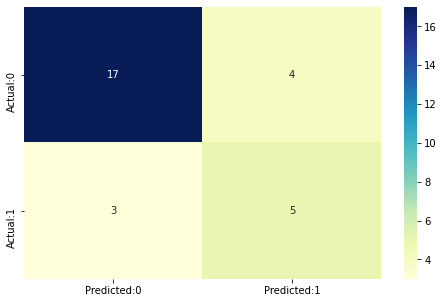

In [98]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_held_out,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Modelo 2

In [132]:
best_model2

GaussianNB(priors=None, var_smoothing=1e-09)

In [125]:
from sklearn.metrics import balanced_accuracy_score

y_pred=best_model2.predict(X_held_out[best_feats2])
print('Exactitud balanceada:', balanced_accuracy_score(y_held_out,y_pred),'\n',
      classification_report(y_held_out, y_pred, target_names=target_names))

Exactitud balanceada: 0.8422619047619048 
                 precision    recall  f1-score   support

No recuperaron       0.94      0.81      0.87        21
   Recuperaron       0.64      0.88      0.74         8

      accuracy                           0.83        29
     macro avg       0.79      0.84      0.80        29
  weighted avg       0.86      0.83      0.83        29



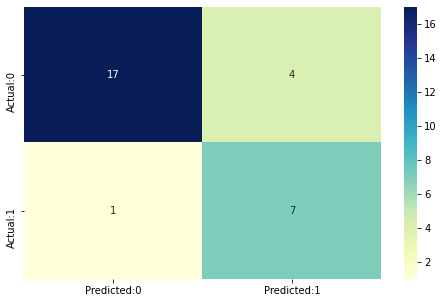

In [100]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_held_out,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

### Modelo 3

In [133]:
best_model3

In [126]:
from sklearn.metrics import balanced_accuracy_score

y_pred=best_model3.predict(X_held_out[best_feats2])
print('Exactitud balanceada:', balanced_accuracy_score(y_held_out,y_pred),'\n',
      classification_report(y_held_out, y_pred, target_names=target_names))

Exactitud balanceada: 0.7172619047619048 
                 precision    recall  f1-score   support

No recuperaron       0.85      0.81      0.83        21
   Recuperaron       0.56      0.62      0.59         8

      accuracy                           0.76        29
     macro avg       0.70      0.72      0.71        29
  weighted avg       0.77      0.76      0.76        29



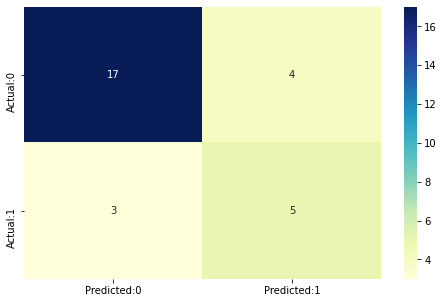

In [102]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_held_out,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

# Guardar datasets de los splits

In [130]:
from google.colab import files
X.to_csv('X.csv')
y.to_csv('y.csv')
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')
X_held_out.to_csv('X_held_out.csv')
y_held_out.to_csv('y_held_out.csv')

files.download('X.csv')
files.download('y.csv')
files.download('X_train.csv')
files.download('y_train.csv')
files.download('X_test.csv')
files.download('y_test.csv')
files.download('X_held_out.csv')
files.download('y_held_out.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>